In [2]:
from astropy.io import fits
from astropy.wcs import WCS
from astropy.utils.data import get_pkg_data_filename
path = '../astrometry_solutions/Luminance/RV_UMa_2022_03_20.fits'
f = fits.open(path)
w = WCS(f[0].header)
sky = w.pixel_to_world(3779.145830844237, 3130.8188850391607)
print(sky)

<SkyCoord (FK5: equinox=2000.0): (ra, dec) in deg
    (203.00567496, 54.18045604)>


In [3]:
import ccdproc as ccdp
data = f[0].data
f.close()

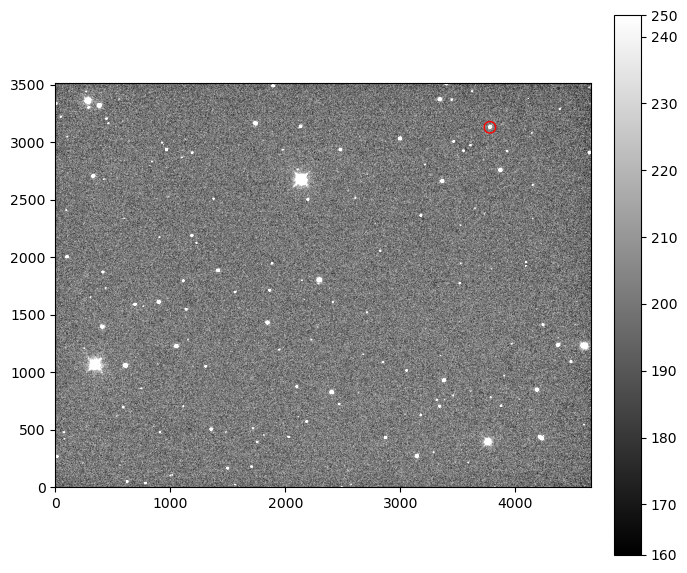

In [4]:
from convenience_functions import show_image
import matplotlib.pyplot as plt

show_image(data, cmap = 'gray')
circle = plt.Circle((3779.145830844237, 3130.8188850391607), 50, color = 'red', fill = False)
#plt.plot(3779.145830844237, 3130.8188850391607, marker = 'x', markersize = 5, color = 'red')
plt.gca().add_patch(circle);

# Finding the galaxy

In [5]:
path_22 = '../reduced-lights_2022_03_22/Luminance/RV_Uma_Light_Luminance_16_secs_001.fits'
data_22 = fits.open(path_22)[0].data

In [6]:
import pandas as pd
import numpy as np
from astropy.stats import sigma_clipped_stats
from photutils.detection import DAOStarFinder

def find_sources(array):
    mean, median, std = sigma_clipped_stats(array, sigma=2.5)
    daofind = DAOStarFinder(fwhm=9.0, threshold=5.*std)
    sources = daofind(array - median)
    return sources

def image_trimmer(sources, array):
    local_df = sources.to_pandas()
    image_size = array.shape
    x_trim = image_size[1] * 0.05
    y_trim = image_size[0] * 0.05
    local_df = local_df[(local_df['xcentroid'] - x_trim > 0) & (local_df['xcentroid'] + x_trim < image_size[1])]
    local_df = local_df[(local_df['ycentroid'] - y_trim > 0) & (local_df['ycentroid'] + y_trim < image_size[0])]
    return local_df.reset_index(drop = True).drop('id', axis = 'columns')

def excluding_duplicates(df, fwhm):
    #Taking initial comparison values from first row
    xcenter, ycenter, flux = df.iloc[0][['xcentroid', 'ycentroid', 'flux']]
    last_index = 0
    #Including first row in result
    filters = [True]

    #Skipping first row in comparisons
    for index, row in df.iloc[1:].iterrows():
        if (xcenter - 3*fwhm <= row['xcentroid'] <= 3*fwhm + xcenter) or (ycenter - 3*fwhm <= row[
            'ycentroid'] <= 3*fwhm + ycenter):
            # Once we have the two that are very close to each other we want to keep the one with the highest flux
            if df.iloc[last_index]['flux'] > row['flux']:
                filters.append(False)
            else:
                filters[last_index] = False
                filters.append(True)
                xcenter = row['xcentroid']
                ycenter = row['ycentroid']
                last_index = index
        else:
            filters.append(True)
            # Updating values to compare based on latest accepted row
            xcenter = row['xcentroid']
            ycenter = row['ycentroid']
            last_index = index
    result = df.loc[filters]
    return result.reset_index(drop=True)

def find_nearest(sources_1, sources_2):
    positions = np.transpose((sources_1['xcentroid'], sources_1['ycentroid']))
    positions_2 = np.transpose((sources_2['xcentroid'], sources_2['ycentroid']))
    mapping_dict = dict()
    for index, value in enumerate(positions):
        difference = np.subtract(positions_2, value)
        squared_difference = np.square(difference)
        min_index = np.sqrt(squared_difference.sum(axis = 1)).argmin()
        if index in mapping_dict:
            old_difference_in_flux = abs(sources_1['flux'][index] - sources_2['flux'][mapping_dict[index]])
            new_difference_in_flux = abs(sources_1['flux'][index] - sources_2['flux'][min_index])
            if old_difference_in_flux > new_difference_in_flux:
                mapping_dict[index] = min_index
        else:
            mapping_dict[index] = min_index
    for key, item in mapping_dict.items():
        x_1, y_1 = sources_1.iloc[key]['xcentroid'], sources_1.iloc[key]['ycentroid']
        x_2, y_2 = sources_2.iloc[item]['xcentroid'], sources_2.iloc[item]['ycentroid']
        distance = np.sqrt((x_1-x_2)**2+(y_1-y_2)**2)
        if distance > 100:
            mapping_dict[key] = np.nan
    return mapping_dict

In [7]:
excluding_duplicates(image_trimmer(find_sources(data_22), data_22), 9)

,xcentroid,ycentroid,sharpness,roundness1,roundness2,npix,sky,peak,flux,mag
0,3156.391594,249.554108,0.516645,-0.116155,0.116770,121,0.0,3456.270919,17.399890,-3.101366
1,3774.859420,372.385663,0.418363,-0.176082,0.113375,121,0.0,39683.362242,209.534232,-5.803137
2,4241.962370,402.728518,0.437584,-0.095012,0.199499,121,0.0,3767.160156,19.913966,-3.247894
3,1369.755034,483.890831,0.425808,0.090861,0.244910,121,0.0,1170.923655,6.491000,-2.030779
4,2199.051980,550.934685,0.498790,-0.176265,-0.116074,121,0.0,469.121673,2.163073,-0.837678
5,3190.672778,605.473713,0.276317,-0.590181,-0.627351,121,0.0,246.736171,1.748737,-0.606811
6,3354.244610,682.036568,0.514145,-0.009588,-0.085311,121,0.0,601.861711,2.995944,-1.191334
7,2417.468544,804.554374,0.386714,-0.187725,0.069454,121,0.0,4402.990399,24.910592,-3.490960
8,2113.502256,855.423164,0.485280,-0.418679,0.127400,121,0.0,447.436723,2.224512,-0.868087
9,3391.216521,907.045080,0.298627,-0.106629,0.062074,121,0.0,2316.674524,14.006902,-2.865855


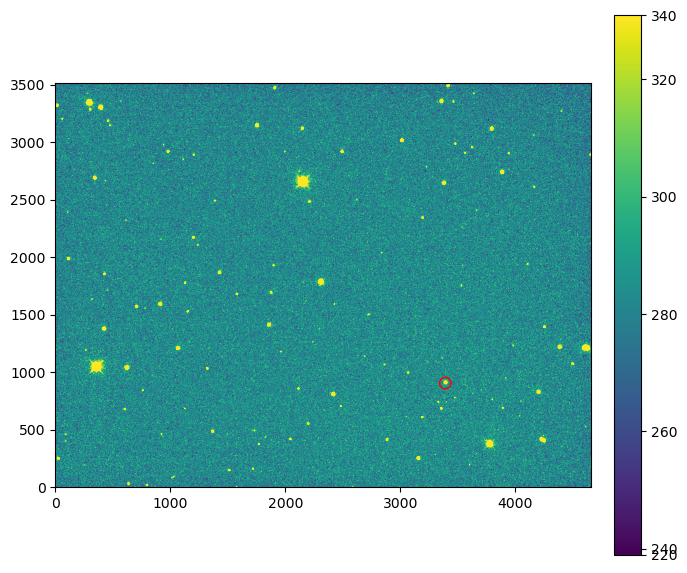

In [8]:
show_image(data_22)
circle = plt.Circle((3391, 907), 50, color = 'red', fill = False)
#plt.plot(3779.145830844237, 3130.8188850391607, marker = 'x', markersize = 5, color = 'red')
plt.gca().add_patch(circle);

# Reading the data

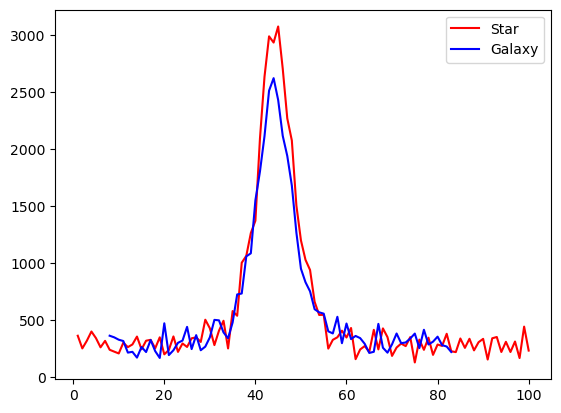

In [22]:


star_data = pd.read_csv('star.dat', sep = '\s+', names = ['index','value'], index_col='index')
galaxy_data = pd.read_csv('galaxy.dat', sep = '\s+', names = ['index','value'], index_col='index')
galaxy_x_axis = np.arange(8, 8+len(galaxy_data), 1)

plt.plot(star_data, color = 'red', label = 'Star')
plt.plot(galaxy_x_axis, galaxy_data, color = 'blue', label = 'Galaxy')
plt.legend()